<a href="https://colab.research.google.com/github/SeojinSeojin/deep-learning_challenge/blob/main/Fashion_Mnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf

fashion_mnist = tf.keras.datasets.fashion_mnist

(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

4423680/4422102 [==============================] - 0s 0us/step


In [2]:
import matplotlib.pyplot as plt
import numpy as np

print(train_labels)
print(test_labels)
# 핫 인코딩
target = train_labels
num = np.unique(target, axis=0)
print(num)
num = num.shape[0]
print(num)
print(np.eye(num)[target])
train_labels = np.eye(num)[target]


target2 = test_labels
num2 = np.unique(target2, axis=0)
num2 = num2.shape[0]
test_labels = np.eye(num2)[target2]
print(train_labels)
print(test_labels)


[9 0 0 ... 3 0 5]
[9 2 1 ... 8 1 5]
[0 1 2 3 4 5 6 7 8 9]
10
[[0. 0. 0. ... 0. 0. 1.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 1.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 1.]
 [0. 0. 1. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 1. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [3]:
train_images = train_images.reshape(-1, 784)
test_images = test_images.reshape(-1, 784)

In [4]:
import numpy as np

In [5]:
## 손실 함수 정의

def cross_entropy_error(y,t):
  if y.ndim==1:
    t = t.reshape(1,t.size)
    y = y.reshape(1,y.size)

  batch_size = y.shape[0]
  return -np.sum(t*np.log(y+1e-7))/batch_size
  

## Forward, Backward 정의

def softmax(x):
    if x.ndim == 2:
        x = x.T
        x = x - np.max(x, axis=0)
        y = np.exp(x) / np.sum(np.exp(x), axis=0)
        return y.T 

    x = x - np.max(x) # 오버플로 대책
    return np.exp(x) / np.sum(np.exp(x))


class Relu:
    def __init__(self):
        self.mask = None

    def forward(self, x):
        self.mask = (x <= 0)
        out = x.copy()
        out[self.mask] = 0

        return out

    def backward(self, dout):
        dout[self.mask] = 0
        dx = dout

        return dx

class Affine:
    def __init__(self, W, b):
        self.W = W
        self.b = b
        
        self.x = None
        self.original_x_shape = None
        # 가중치와 편향 매개변수의 미분
        self.dW = None
        self.db = None

    def forward(self, x):
        # 텐서 대응
        self.original_x_shape = x.shape
        x = x.reshape(x.shape[0], -1)
        self.x = x

        out = np.dot(self.x, self.W) + self.b

        return out

    def backward(self, dout):
        dx = np.dot(dout, self.W.T)
        self.dW = np.dot(self.x.T, dout)
        self.db = np.sum(dout, axis=0)
        
        dx = dx.reshape(*self.original_x_shape)  # 입력 데이터 모양 변경(텐서 대응)
        return dx


class SoftmaxWithLoss:
    def __init__(self):
        self.loss = None # 손실함수
        self.y = None    # softmax의 출력
        self.t = None    # 정답 레이블(원-핫 인코딩 형태)
        
    def forward(self, x, t):
        self.t = t
        self.y = softmax(x)
        self.loss = cross_entropy_error(self.y, self.t)
        
        return self.loss

    def backward(self, dout=1):
        batch_size = self.t.shape[0]
        if self.t.size == self.y.size: # 정답 레이블이 원-핫 인코딩 형태일 때
            dx = (self.y - self.t) / batch_size
        else:
            dx = self.y.copy()
            dx[np.arange(batch_size), self.t] -= 1
            dx = dx / batch_size
        
        return dx

In [6]:
## 3층 신경망 클래스 정의
from collections import OrderedDict

class ThreeLayerNet:
  def __init__(self, input_size, hidden_size1, hidden_size2, output_size, weight_init_std=0.01):
    self.params = {}
    self.params["W1"] = weight_init_std * np.random.randn(input_size, hidden_size1)
    self.params["b1"] = np.zeros(hidden_size1)
    self.params["W2"] = weight_init_std * np.random.randn(hidden_size1, hidden_size2)
    self.params["b2"] = np.zeros(hidden_size2)
    self.params["W3"] = weight_init_std * np.random.randn(hidden_size2, output_size)
    self.params["b3"] = np.zeros(output_size)

    # 계층 생성
    self.layers = OrderedDict()
    self.layers['Affine1'] = Affine(self.params['W1'], self.params['b1'])
    self.layers['Relu1'] = Relu()
    self.layers['Affine2'] = Affine(self.params['W2'], self.params['b2'])
    self.layers['Relu2'] = Relu()
    self.layers['Affine3'] = Affine(self.params['W3'], self.params['b3'])
    self.lastLayer = SoftmaxWithLoss()

  def predict(self, x):
    for layer in self.layers.values():
      x = layer.forward(x)
        
    return x
  
  def loss(self, x, t):
    y = self.predict(x)

    return self.lastLayer.forward(y, t)
  
  def accuracy(self, x, t):
    y = self.predict(x)
    y = np.argmax(y, axis=1)
    t = np.argmax(t, axis=1)
    
    if t.ndim != 1 : t = np.argmax(t, axis=1)
    
    accuracy = np.sum(y == t) / float(x.shape[0])
    return accuracy
  
  def gradient(self, x, t):
    # forward
    self.loss(x, t)

    # backward
    dout = 1
    dout = self.lastLayer.backward(dout)
    
    layers = list(self.layers.values())
    layers.reverse()
    for layer in layers:
        dout = layer.backward(dout)

    # 결과 저장
    grads = {}
    grads['W1'], grads['b1'] = self.layers['Affine1'].dW, self.layers['Affine1'].db
    grads['W2'], grads['b2'] = self.layers['Affine2'].dW, self.layers['Affine2'].db
    grads['W3'], grads['b3'] = self.layers['Affine3'].dW, self.layers['Affine3'].db

    return grads

In [11]:
import time

def train(batch_size=100, learning_rate=0.01):

  train_loss_list = []
  train_acc_list = []
  test_acc_list = []

  iters_num = 10000
  train_size = train_images.shape[0]

  iter_per_epoch = max(train_size / batch_size, 1)
  print("epoch =", iter_per_epoch)

  network = ThreeLayerNet(input_size=784, hidden_size1=200, hidden_size2=100, output_size=10)

  for i in range(iters_num):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = train_images[batch_mask]
    t_batch = train_labels[batch_mask]

    grad = network.gradient(x_batch, t_batch)

    for key in ("W1", "b1", "W2", "b2", "W3", "b3"):
      network.params[key] -= learning_rate * grad[key]

    loss = network.loss(x_batch, t_batch)
    train_loss_list.append(loss)

    if i % iter_per_epoch == 0:
      train_acc = network.accuracy(train_images, train_labels)
      test_acc = network.accuracy(test_images, test_labels)
      print(f"{i} train acc : test acc = {train_acc} : {test_acc}")
      train_acc_list.append(train_acc)
      test_acc_list.append(test_acc)
  
  plt_x1 = np.arange(len(train_acc_list))
  plt_y1 = train_acc_list
  plt_x2 = np.arange(len(test_acc_list))
  plt_y2 = test_acc_list
  plt_x3 = np.arange(len(train_loss_list))
  plt_y3 = train_loss_list
  plt.subplot(311)
  plt.plot(plt_x1[1:], plt_y1[1:], 'r-')
  plt.subplot(312)
  plt.plot(plt_x2[1:], plt_y2[1:], 'r-')
  plt.subplot(313)
  plt.plot(plt_x3[1:], plt_y3[1:])
  plt.show()

epoch = 600.0
0 train acc : test acc = 0.2762 : 0.2767
600 train acc : test acc = 0.7860666666666667 : 0.7756
1200 train acc : test acc = 0.8519666666666666 : 0.8376
1800 train acc : test acc = 0.8699 : 0.8507
2400 train acc : test acc = 0.8654666666666667 : 0.8448
3000 train acc : test acc = 0.8908666666666667 : 0.868
3600 train acc : test acc = 0.8949333333333334 : 0.868
4200 train acc : test acc = 0.8943166666666666 : 0.8655
4800 train acc : test acc = 0.9008833333333334 : 0.8745
5400 train acc : test acc = 0.9039166666666667 : 0.8763
6000 train acc : test acc = 0.908 : 0.8771
6600 train acc : test acc = 0.8982 : 0.8709
7200 train acc : test acc = 0.9166 : 0.8838
7800 train acc : test acc = 0.9179166666666667 : 0.8854
8400 train acc : test acc = 0.91435 : 0.881
9000 train acc : test acc = 0.9224 : 0.8887
9600 train acc : test acc = 0.9143166666666667 : 0.8799


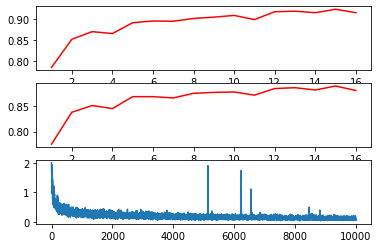

In [12]:
train()